### Importy

In [1]:
import pandas as pd
from scripts.strategy_functions import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import optuna
import numpy as np
from scripts.train_utilities import calculate_metrics_2, calculate_classification_metrics

In [2]:
# Wczytanie danych aktywów i zapisanie ich w słowniku
prefix_list = ['BA','BTC-USD','NFLX','TSLA']
option_list = ['full','fin','news']

dict_df = {}
for prefix in prefix_list:
    for option in option_list:
        df = pd.read_csv(f'csv/{prefix}/{prefix}_pred_{option}.csv')
        df = df[((df["Date"] >= "2021-01-01") & (df["Date"] <= "2023-11-24"))]
            
        dict_df.update( {f"{prefix}_{option}": df})

In [3]:
for prefix in prefix_list:
    if prefix == 'BTC-USD':
        df  = pd.read_csv(f'csv/{prefix}/{prefix}_with_weekends.csv')
        step = 7
    else:
        df  = pd.read_csv(f'csv/{prefix}/{prefix}_without_weekends.csv')
        step = 5

    for option in option_list:
        pred_val = dict_df[f"{prefix}_{option}"]
        df_val = get_close_pred(pred_val, df, prefix, step)
        dict_df.update( {f"{prefix}_{option}": df_val})

### Wykresy predykcji

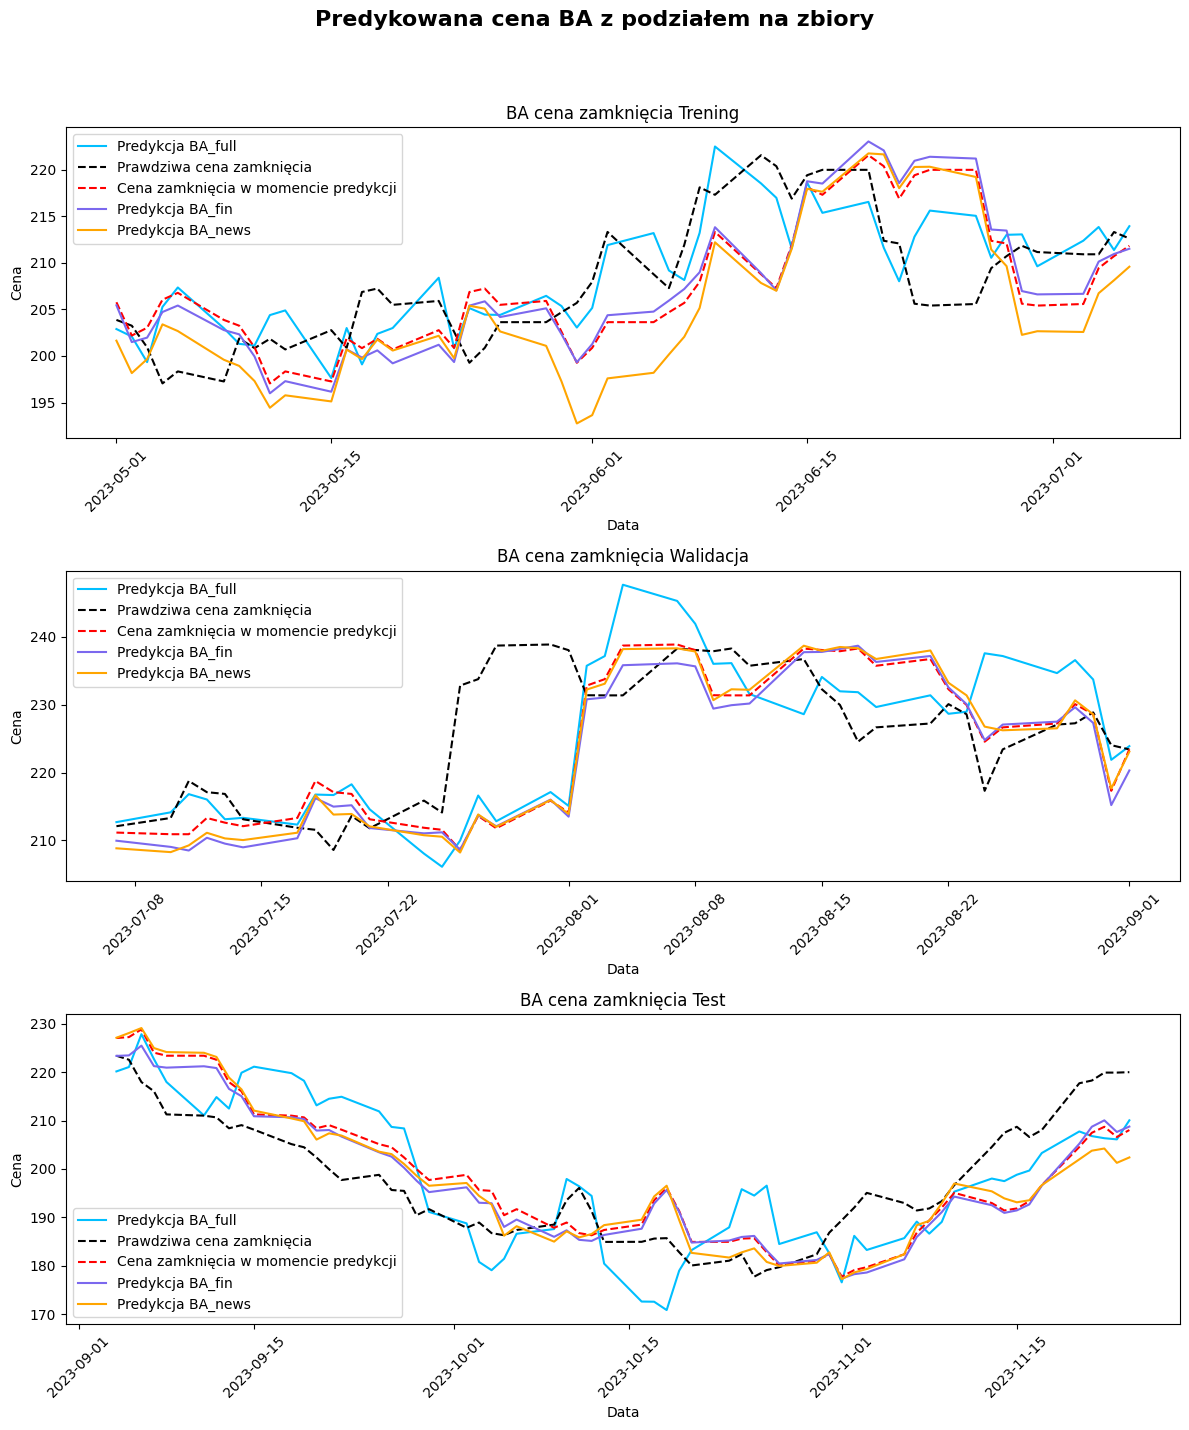

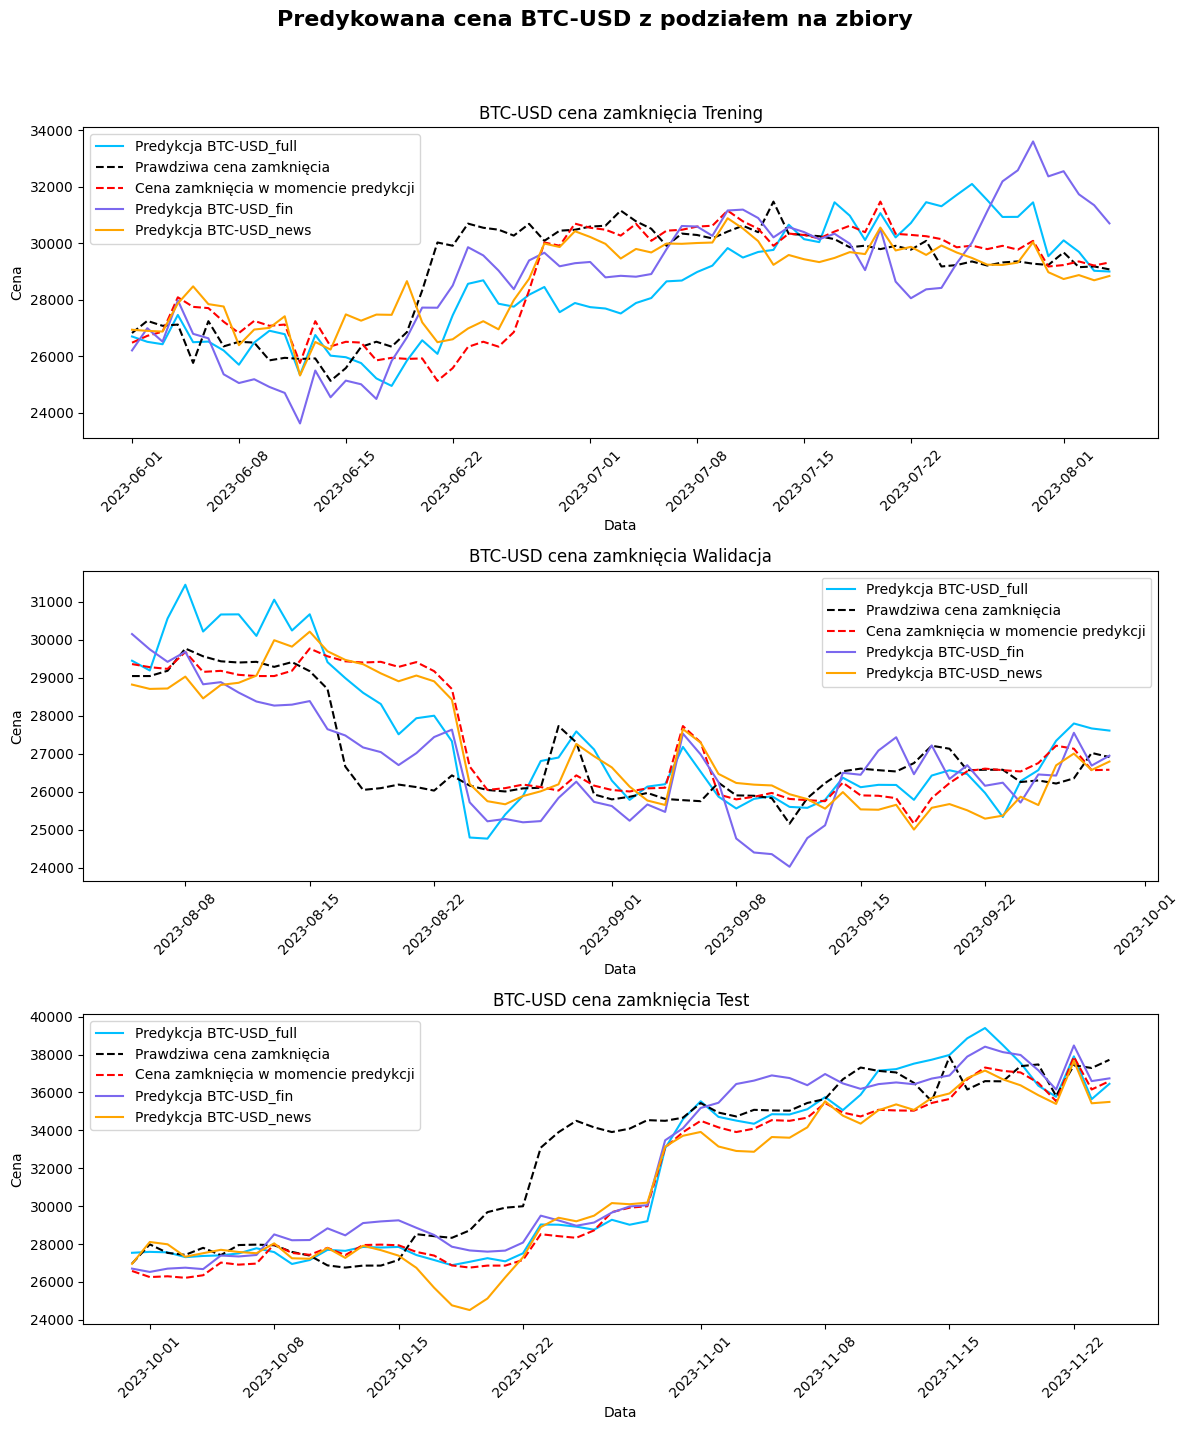

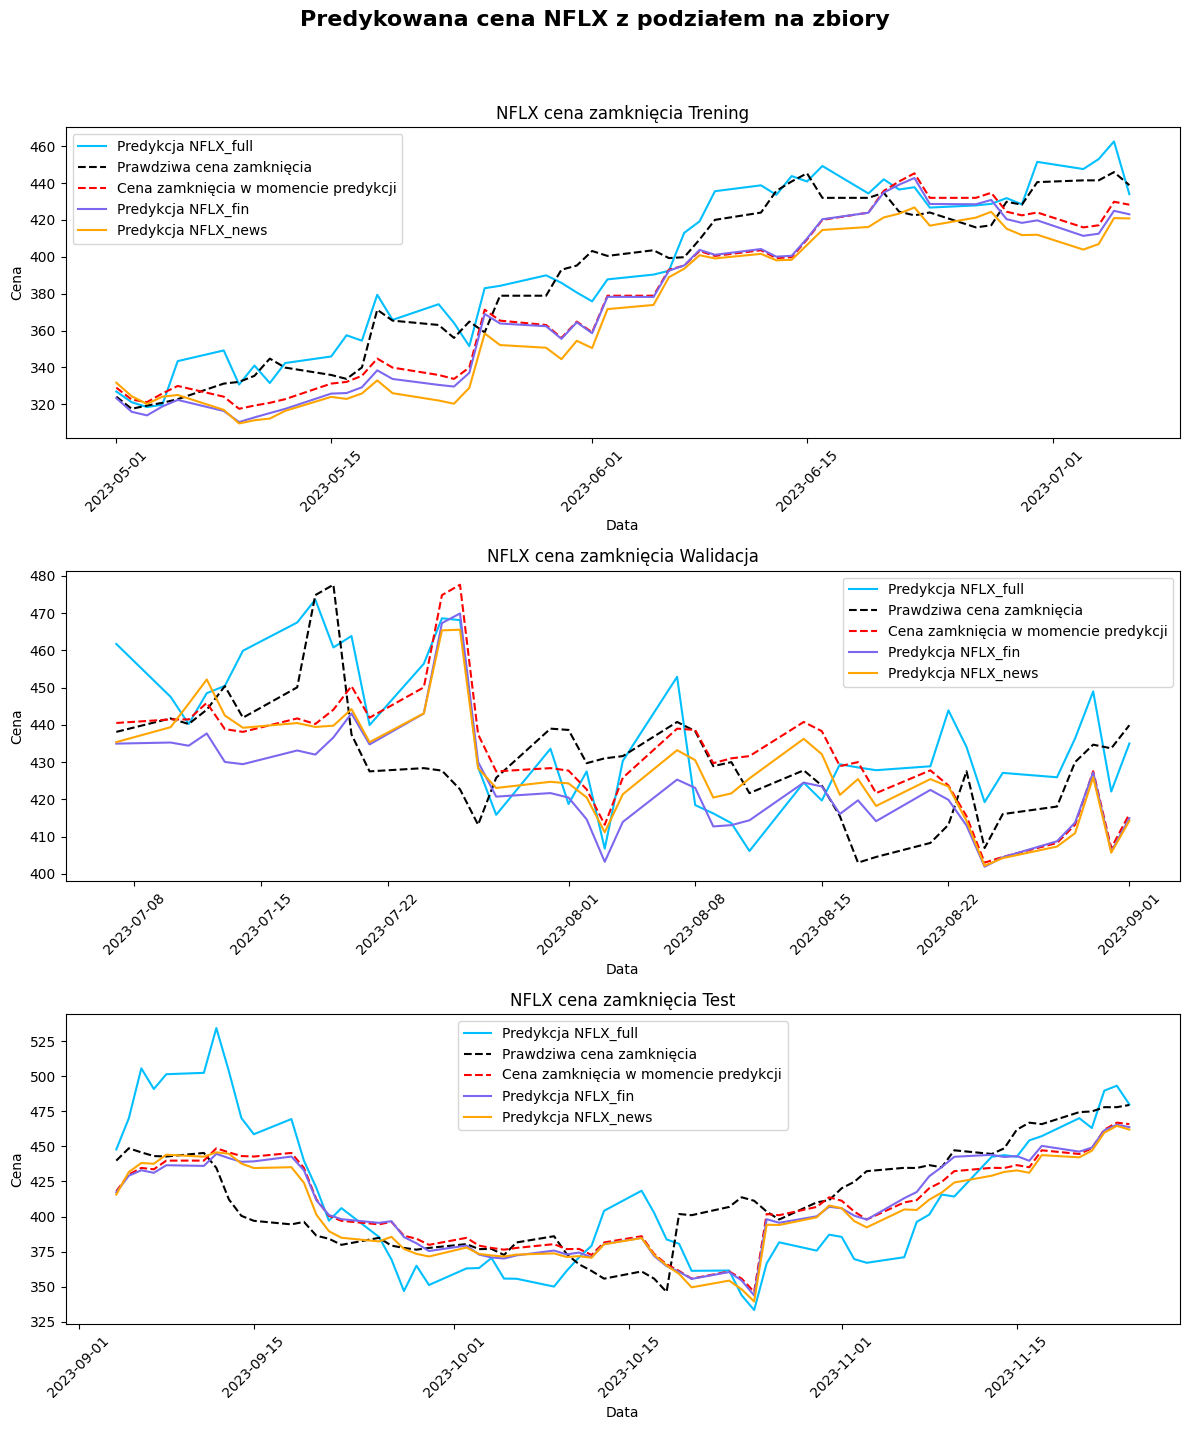

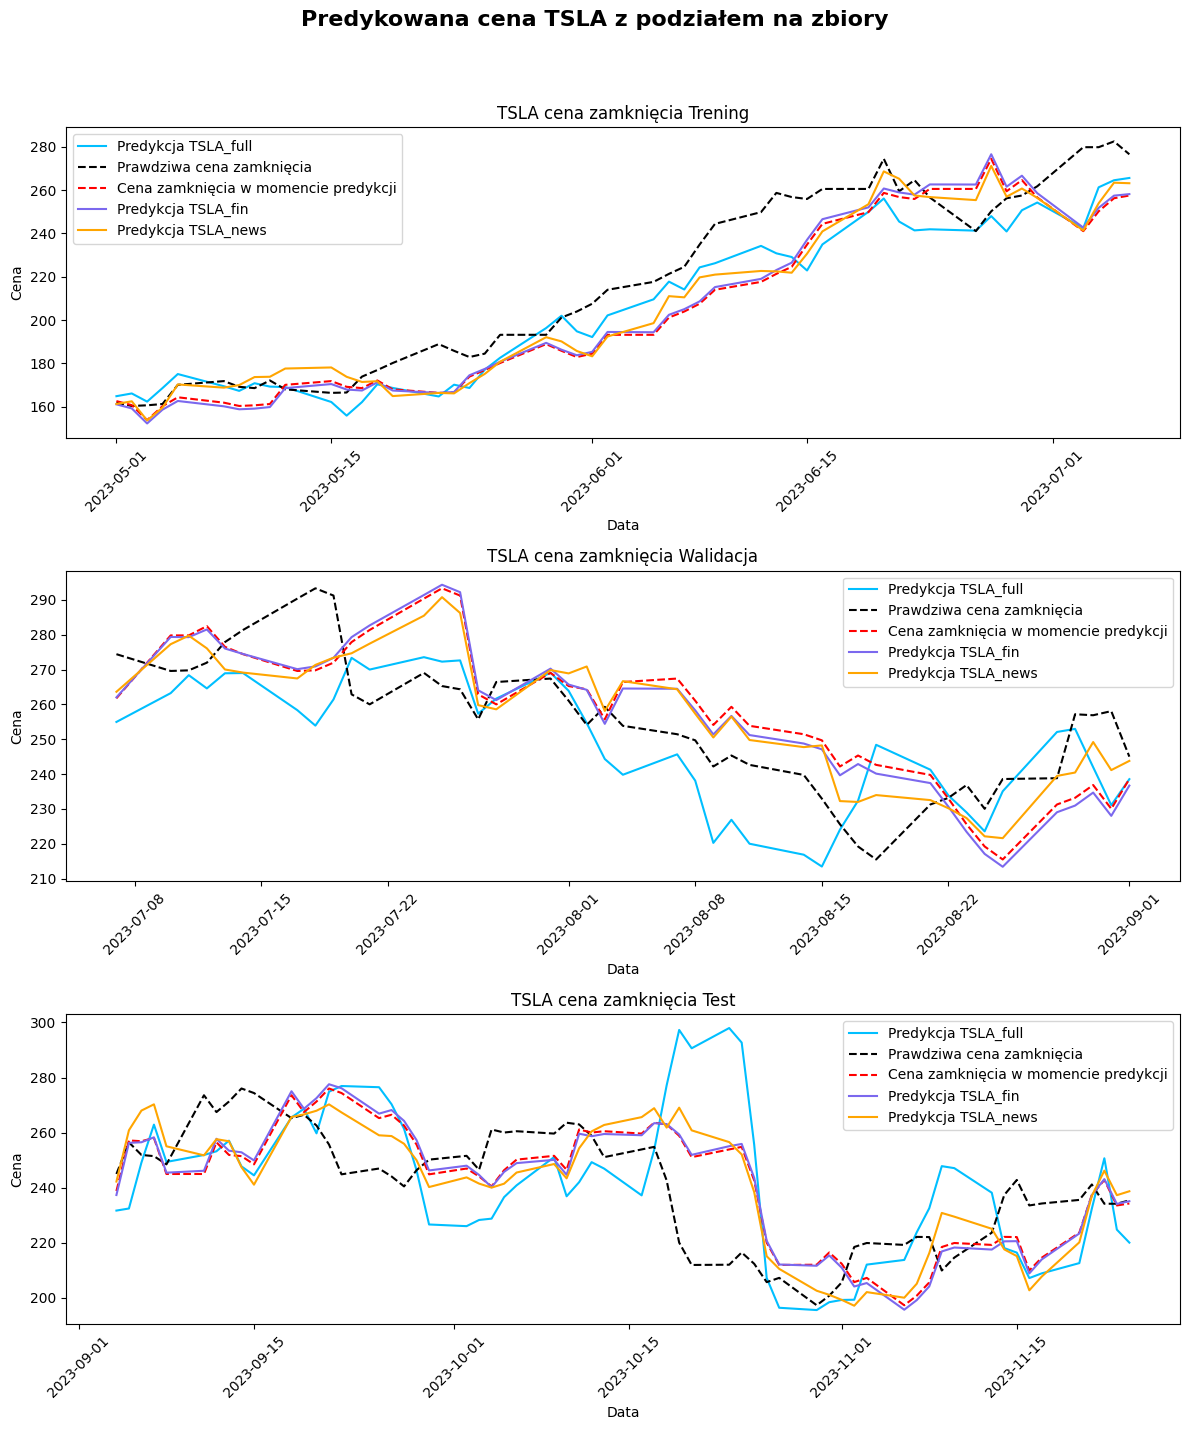

In [65]:
color_list = ['deepskyblue', 'mediumslateblue', 'orange']

for prefix in prefix_list:
    plt.figure(figsize=(12, 15))
    plt.suptitle(f'Predykowana cena {prefix} z podziałem na zbiory', fontsize=16, fontweight='bold')

    if prefix == 'BTC-USD':
        train_start_date = '2023-06-01'
        train_end_date = '2023-08-04'
        val_start_date = '2023-08-05'
        val_end_date = '2023-09-29'
        test_start_date = '2023-09-30'

    else:
        train_start_date = '2023-05-01'
        train_end_date = '2023-07-06'
        val_start_date = '2023-07-07'
        val_end_date = '2023-09-01'
        test_start_date = '2023-09-02'

    for i, (data_range, title) in enumerate(zip(
        [(train_start_date, train_end_date), (val_start_date, val_end_date), (test_start_date, None)],
        ['Trening', 'Walidacja', 'Test'])):
        ax = plt.subplot(3, 1, i + 1)  

        for j, option in enumerate(option_list):
            df = dict_df[f"{prefix}_{option}"]
            
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date')
            
            data = df[data_range[0]:data_range[1]]  

            plt.plot(data.index, data['Close_pred'], label=f"Predykcja {prefix}_{option}", color=color_list[j])
            if j == 0: 
                plt.plot(data.index, data['Close'], label='Prawdziwa cena zamknięcia', color='black', linestyle='--')
                plt.plot(data.index, data['Close_buy'], label='Cena zamknięcia w momencie predykcji', color='red', linestyle='--')


        plt.xlabel('Data')
        plt.ylabel('Cena')
        plt.title(f'{prefix} cena zamknięcia {title}')
        plt.legend()

        ax.xaxis.set_major_locator(mdates.AutoDateLocator()) 
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
        plt.xticks(rotation=45)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

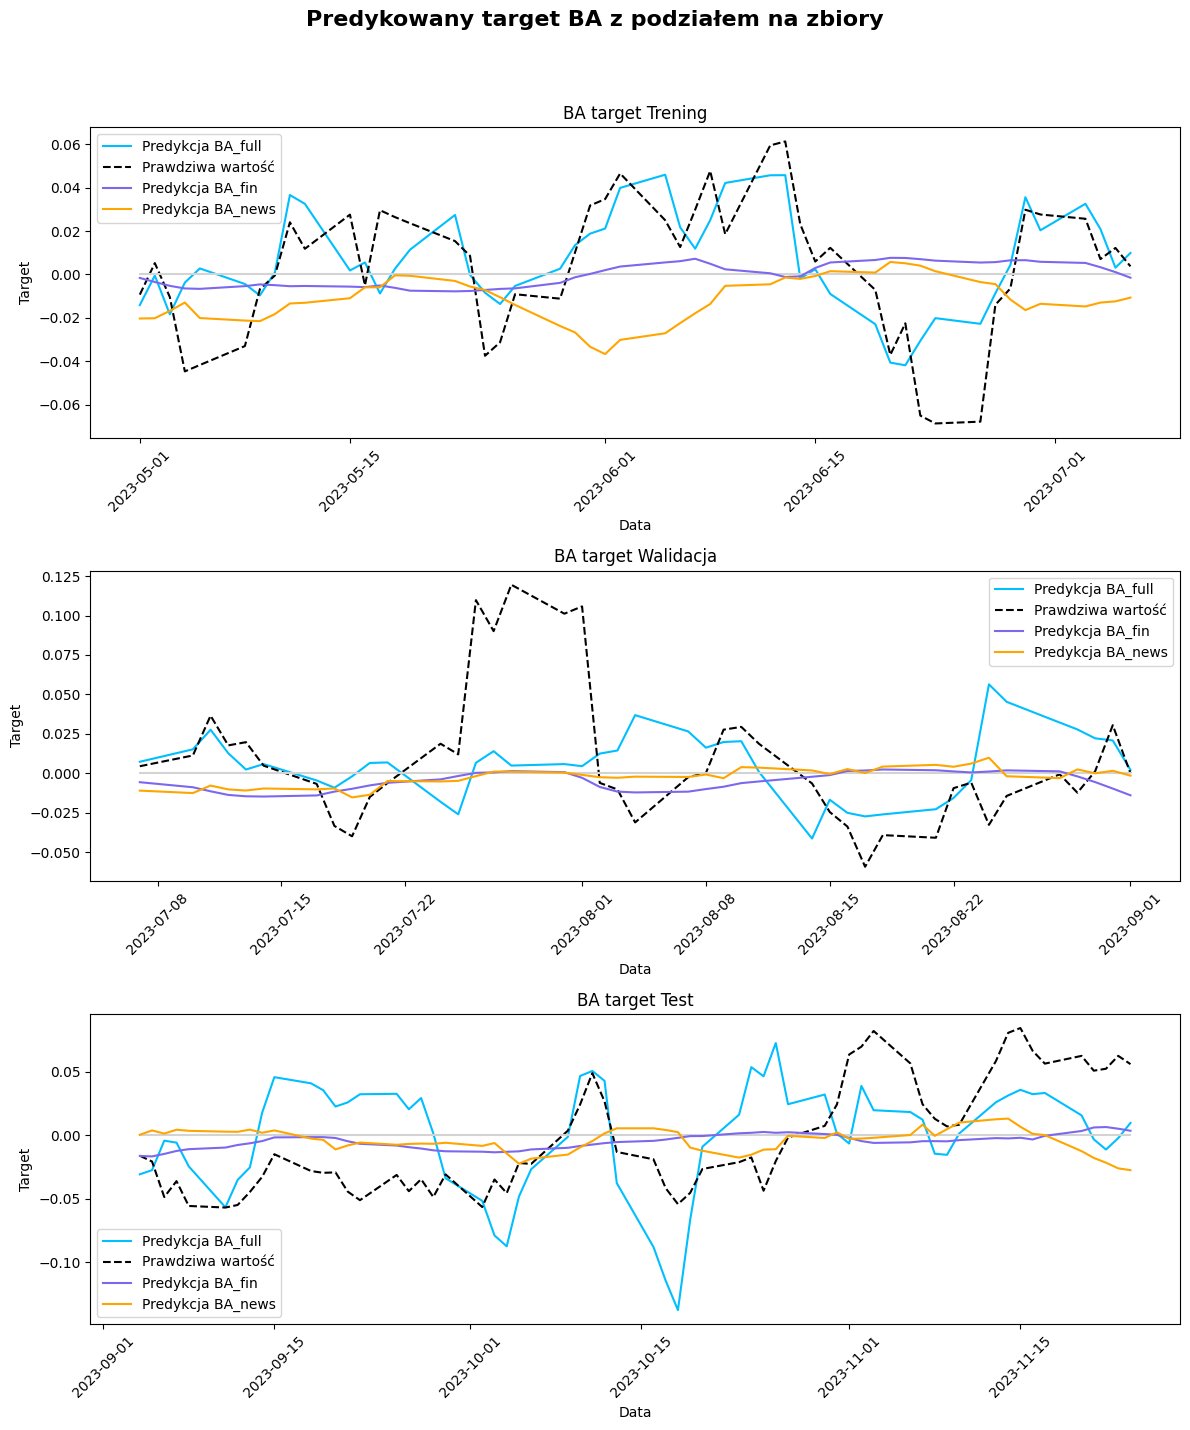

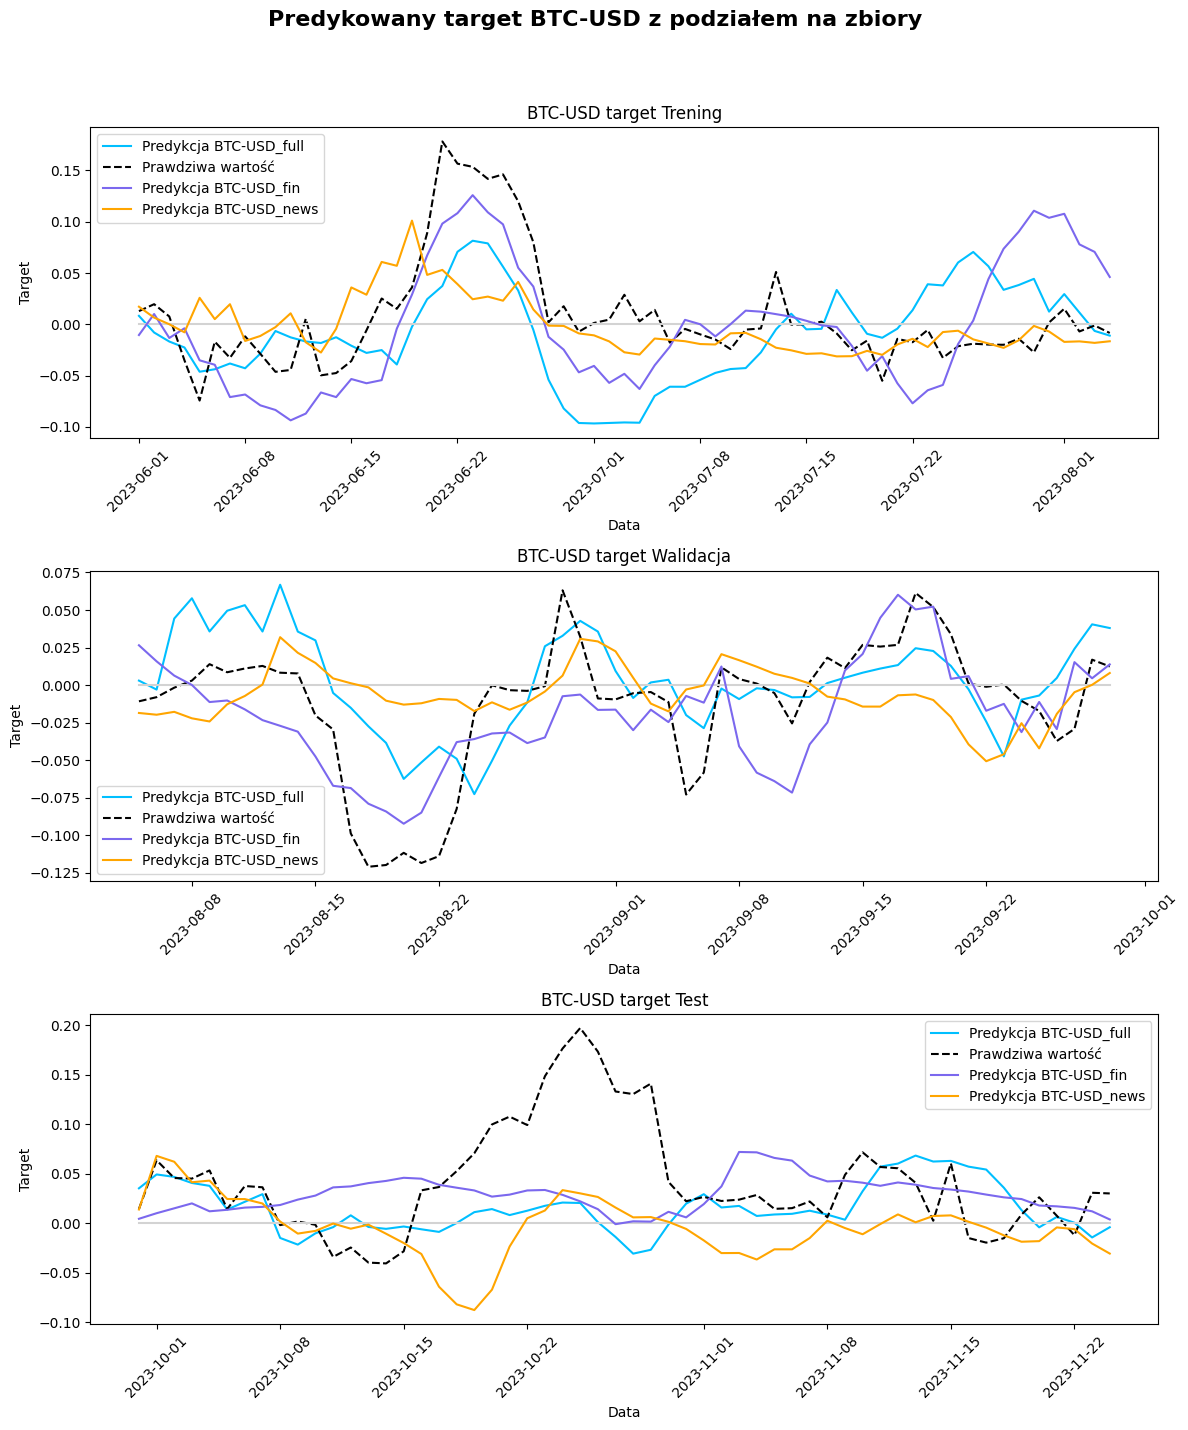

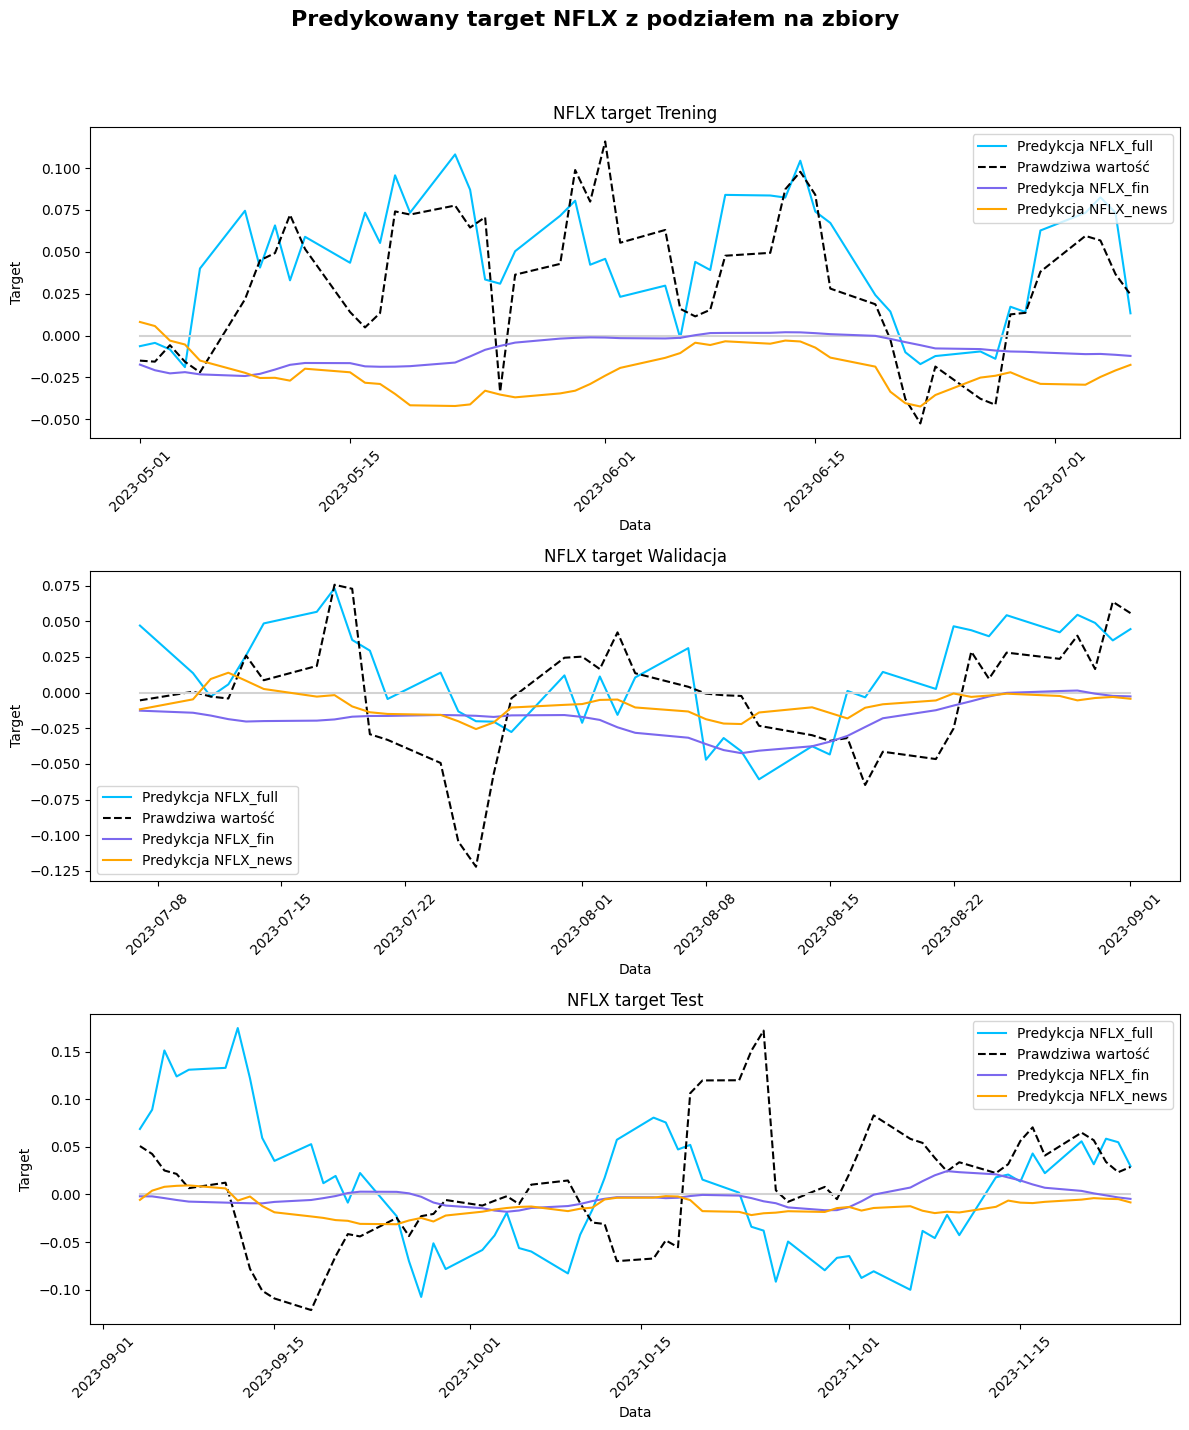

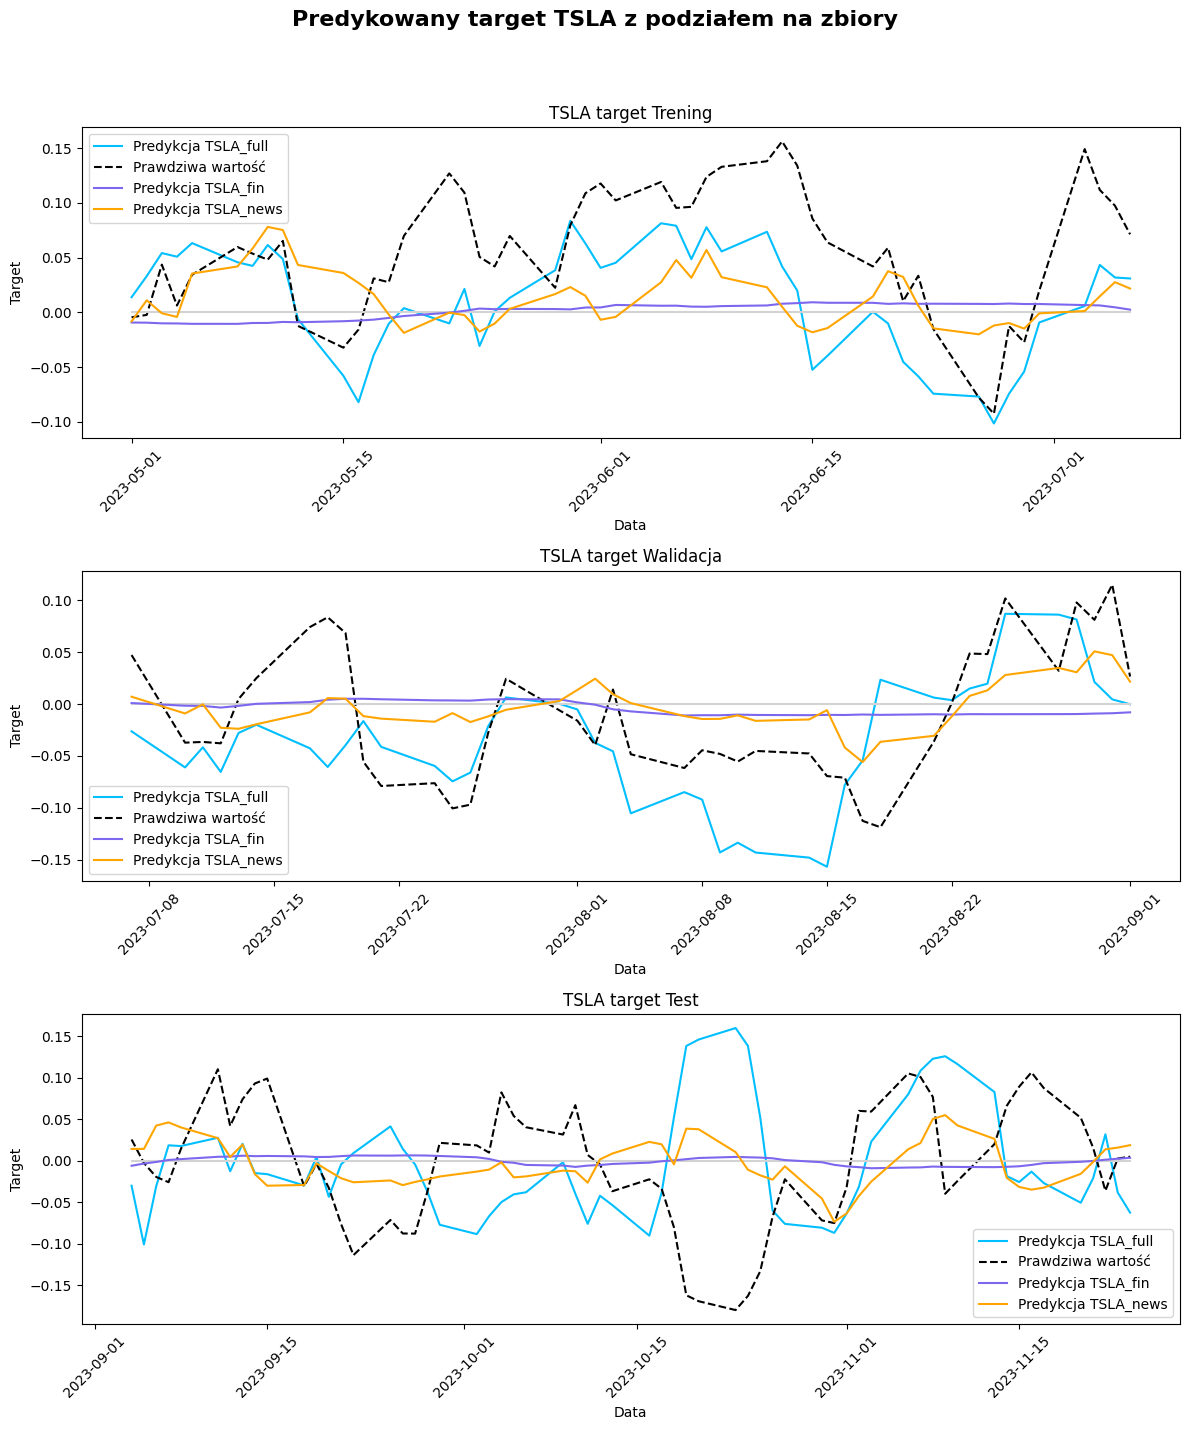

In [66]:
for prefix in prefix_list:
    plt.figure(figsize=(12, 15))
    plt.suptitle(f'Predykowany target {prefix} z podziałem na zbiory', fontsize=16, fontweight='bold')

    if prefix == 'BTC-USD':
        train_start_date = '2023-06-01'
        train_end_date = '2023-08-04'
        val_start_date = '2023-08-05'
        val_end_date = '2023-09-29'
        test_start_date = '2023-09-30'

    else:
        train_start_date = '2023-05-01'
        train_end_date = '2023-07-06'
        val_start_date = '2023-07-07'
        val_end_date = '2023-09-01'
        test_start_date = '2023-09-02'

    for i, (data_range, title) in enumerate(zip(
        [(train_start_date, train_end_date), (val_start_date, val_end_date), (test_start_date, None)],
        ['Trening', 'Walidacja', 'Test'])):
        ax = plt.subplot(3, 1, i + 1) 

        for j, option in enumerate(option_list):
            df = dict_df[f"{prefix}_{option}"]
            
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date')
            
            data = df[data_range[0]:data_range[1]] 

            plt.plot(data.index, data['pred'], label=f"Predykcja {prefix}_{option}", color=color_list[j])
            if j == 0:  
                plt.plot(data.index, data['Target'], label='Prawdziwa wartość', color='black', linestyle='--')
                plt.plot(data.index, [0] * len(data.index), color='lightgrey')  

        plt.xlabel('Data')
        plt.ylabel('Target')
        plt.title(f'{prefix} target {title}')
        plt.legend()

        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45) 

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
# Wyświetlenie korelacji pomiędzy ceną zamknięcia a predykcją transformowaną do ceny zamknięcia
for prefix in prefix_list:
    
    if prefix == 'BTC-USD':
        train_start_date = '2023-01-01'
        train_end_date = '2023-08-04'
        val_start_date = '2023-08-05'
        val_end_date = '2023-09-29'
        test_start_date = '2023-09-30'

    else:
        train_start_date = '2023-01-01'
        train_end_date = '2023-07-06'
        val_start_date = '2023-07-07'
        val_end_date = '2023-09-01'
        test_start_date = '2023-09-02'
    
    for i, (data_range, title) in enumerate(zip(
    [(train_start_date, train_end_date), (val_start_date, val_end_date), (test_start_date, None)],
    ['Trening', 'Walidacja', 'Test'])):

        for j, option in enumerate(option_list):
            df = dict_df[f"{prefix}_{option}"]
                
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date')
            
            data = df[data_range[0]:data_range[1]]
            correlation = data['Close'].corr(data['Close_pred'])
            print(f'Korelacja Ceny zamknięcia a predykcji {title} {prefix}_{option}:', correlation)


### Zwrot ze strategii dla LSTM

In [12]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial, df, intrest):
    thr_p = trial.suggest_uniform('thr_p', 0.01, 5)
    thr_m = trial.suggest_uniform('thr_m', -5, -0.01)

    mean_return, _ = calculate_return(df, intrest, thr_p, thr_m)
    return mean_return

def optimize_parameters_with_optuna(df, intrest):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, df, intrest), n_trials=600) 

    best_params = study.best_params
    max_mean_return = study.best_value  

    return best_params, max_mean_return

In [15]:
df_final = pd.DataFrame(columns=['Prefix', 'Intrest', 'Thr_p', 'Thr_m', 'Mean_return_val', 'Mean_return_test','n_transactions_test','n_transactions_val'])

for prefix in prefix_list:    

    if prefix == "NFLX":
        df = dict_df[f"{prefix}_fin"]
        val_start_date = '2023-07-07'
        val_end_date = '2023-09-01'
        test_start_date = '2023-09-02'
        
    elif prefix == "BTC-USD":
        val_start_date = '2023-08-05'
        val_end_date = '2023-09-29'
        test_start_date = '2023-09-30'
        df = dict_df[f"{prefix}_full"]

    elif prefix == "TSLA":
        val_start_date = '2023-07-07'
        val_end_date = '2023-09-01'
        test_start_date = '2023-09-02'
        df = dict_df[f"{prefix}_news"]
            
    elif prefix == "BA":
        val_start_date = '2023-07-07'
        val_end_date = '2023-09-01'
        test_start_date = '2023-09-02'
        df = dict_df[f"{prefix}_full"]
        
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    
    data_val = df[val_start_date:val_end_date]
    data_test = df[test_start_date:]

    for intrest in [0,0.002]:

        best_params, _ = optimize_parameters_with_optuna(data_val, intrest)
        mean_return, return_list = calculate_return(data_test, intrest, thr_p=best_params.get('thr_p'), thr_m=best_params.get('thr_m'))
        mean_return_val, return_list_val = calculate_return(data_val, intrest, thr_p=best_params.get('thr_p'), thr_m=best_params.get('thr_m'))
       

        df_final.loc[len(df_final)] = [prefix, intrest, best_params.get("thr_p"), best_params.get("thr_m"), mean_return_val, mean_return, len(return_list), len(return_list_val)]    

C:\Users\HP\AppData\Local\Temp\ipykernel_6396\4202312842.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  thr_p = trial.suggest_uniform('thr_p', 0.01, 5)
C:\Users\HP\AppData\Local\Temp\ipykernel_6396\4202312842.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  thr_m = trial.suggest_uniform('thr_m', -5, -0.01)
C:\Users\HP\AppData\Local\Temp\ipykernel_6396\4202312842.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  thr_p = trial.suggest_uniform('thr_p', 0.01, 5)
C:\Users\HP\AppData\Local\Temp\ipykernel_6396\4202312842.py:5: FutureWarning: suggest_uniform has 

In [17]:
df_final

,Prefix,Intrest,Thr_p,Thr_m,Mean_return_val,Mean_return_test,n_transactions_test,n_transactions_val
0,BA,0.000,0.056164,-0.519982,0.720718,0.720945,55,38
1,BA,0.002,0.277137,-0.634235,0.574085,0.574117,51,36
2,BTC-USD,0.000,0.822783,-0.266048,1.325369,1.228608,49,47
3,BTC-USD,0.002,0.760357,-0.255110,1.138605,1.028362,49,47
4,NFLX,0.000,0.026844,-1.554561,0.314598,0.602272,28,27
5,NFLX,0.002,0.061142,-1.468944,0.207145,0.472924,29,27
6,TSLA,0.000,3.598610,-0.585469,1.278240,-0.325515,36,25
7,TSLA,0.002,2.589988,-0.488172,1.179245,-0.572308,42,25


### Statystyki dla modeli LSTM

In [60]:
metrics_list = []

for prefix in prefix_list:
        
    if prefix == "BTC-USD":
        step = 7
        train_start_date = '2021-01-01'
        train_end_date = '2023-08-11'
        val_start_date = '2023-08-12'
        val_end_date = '2023-10-06'
        test_start_date = '2023-10-07'

    else:
        step = 5
        train_start_date = '2021-01-01'
        train_end_date = '2023-07-14'
        val_start_date = '2023-07-14'
        val_end_date = '2023-09-09'
        test_start_date = '2023-09-10'


    for i, (data_range, title) in enumerate(zip(
        [(train_start_date, train_end_date), (val_start_date, val_end_date), (test_start_date, None)],
        ['Training', 'Validation', 'Testing'])):

        for option in option_list:
            df = dict_df[f"{prefix}_{option}"]
            df['Baseline'] = df['Target'].shift(step).fillna(0)
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date')

            y_true = df[data_range[0]:data_range[1]]['Target']
            y_pred = df[data_range[0]:data_range[1]]['pred']

            norm_metrics = calculate_metrics_2(y_true, y_pred)  
            additional_metrics = calculate_classification_metrics(y_true, y_pred)
            all_metrics = {**norm_metrics, **additional_metrics}

            metrics_list.append({**all_metrics, 'Model': f'{prefix}_{option}_{title}'})

        y_baseline = df[data_range[0]:data_range[1]]['Baseline']
        
        norm_metrics = calculate_metrics_2(y_true, y_baseline)  
        additional_metrics = calculate_classification_metrics(y_true, y_baseline)
        all_metrics = {**norm_metrics, **additional_metrics}

        metrics_list.append({**all_metrics, 'Model': f'{prefix}_baseline_{title}'})


df_metrics = pd.DataFrame(metrics_list)

In [61]:
df_metrics.drop(columns=['MSE'],inplace=True)

In [62]:
df_metrics

,MAE,RMSE,R2 Score,MAPE,Accuracy,Precision,Recall,F1 Score,AUC,Model
0,0.017163,0.022217,0.823768,164.419168,0.829047,0.797954,0.901734,0.846676,0.915552,BA_full_Training
1,0.038493,0.051901,0.055703,127.308441,0.572755,0.584810,0.673469,0.626016,0.602546,BA_fin_Training
2,0.042087,0.055251,-0.070139,222.501261,0.464396,0.495050,0.437318,0.464396,0.494039,BA_news_Training
3,0.058246,0.077301,-1.094683,551.468595,0.500000,0.529586,0.521866,0.525698,0.484206,BA_baseline_Training
4,0.033194,0.045082,-0.029453,729.134832,0.682927,0.521739,0.857143,0.648649,0.634921,BA_full_Validation
5,0.030300,0.043764,0.029866,1068.379956,0.536585,0.307692,0.285714,0.296296,0.550265,BA_fin_Validation
6,0.031393,0.044832,-0.018047,201.913499,0.463415,0.300000,0.428571,0.352941,0.441799,BA_news_Validation
7,0.053874,0.067386,-1.300027,3283.263383,0.390244,0.210526,0.285714,0.242424,0.354497,BA_baseline_Validation
8,0.041650,0.048600,-0.206337,157.219164,0.581818,0.515152,0.708333,0.596491,0.633065,BA_full_Testing
9,0.037044,0.042622,0.072194,102.412048,0.600000,0.583333,0.291667,0.388889,0.650538,BA_fin_Testing


In [63]:
df_metrics.to_csv('csv/metrics.csv', index=False)